# Facial Expression Recognition

This project is about an facial expression recognition using transfer learning techniques. The primary objective is to develop a deep learning model that can accurately classify human emotions based on facial images.It has broad applications, from enhancing human-computer interaction and personalizing user experiences to aiding mental health monitoring and bolstering sentiment analysis for business insights.<br><br>
**About Dataset**<br>
[Face expression recognition dataset](https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset)<br>
This Dataset from Kaggle consists of a diverse collection of facial images, each annotated with the emotion expressed by the subject. It has 28709 training images and 7178 testing images

##  Installing and Importing Libraries

In [1]:
!pip install augmentor
!pip install pydot
!pip install graphviz
!pip install efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import zipfile
import random
import Augmentor
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, GlobalMaxPooling2D, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from efficientnet.tfkeras import EfficientNetB0
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn import set_config
from keras.utils import plot_model

In [3]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mitaliadmuthe@gmail.com
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/aadityasinghal/facial-expression-dataset


100%|██████████| 60.7M/60.7M [00:00<00:00, 73.2MB/s]


In [4]:
import os
dataset = './facial-expression-dataset'
print(os.listdir(dataset))

['train', 'test']


In [5]:
classes = os.listdir(dataset + "/train"+ "/train")
print(classes)

['fear', 'disgust', 'neutral', 'angry', 'surprise', 'sad', 'happy']


In [6]:
data_dir = dataset

train_dir = data_dir + '/train' + '/train'
test_dir = data_dir + '/test' + '/test'

In [7]:
count = []
for folder in classes:
    num_images = len(os.listdir(train_dir+'/'+ folder))
    count.append(num_images)
    print(f'There are {num_images} images in the {folder} category.')

There are 4097 images in the fear category.
There are 436 images in the disgust category.
There are 4965 images in the neutral category.
There are 3995 images in the angry category.
There are 3171 images in the surprise category.
There are 4830 images in the sad category.
There are 7215 images in the happy category.


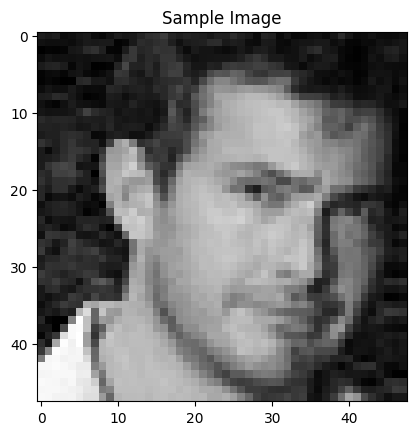

In [8]:
# Sample Image
image_path = train_dir+'/angry/Training_10120469.jpg'
img = mpimg.imread(image_path)
plt.imshow(img, cmap='gray')
plt.title('Sample Image')
plt.show()

In [9]:
image_path = train_dir+'/angry/Training_10120469.jpg'
img = mpimg.imread(image_path)
img.shape

(48, 48)

In [10]:
# number of channels
image = cv2.imread(train_dir+'/angry/Training_10120469.jpg')
image.shape[2] if len(image.shape) == 3 else 1

3

In [11]:
def plot_no_of_images(training_folder):
    categories = []
    image_counts = []

    for category in os.listdir(training_folder):
        category_path = os.path.join(training_folder, category)
        if os.path.isdir(category_path):
            categories.append(category)
            image_count = len(os.listdir(category_path))
            image_counts.append(image_count)

    plt.figure(figsize=(10, 6))
    plt.bar(categories, image_counts, color='royalblue', width=0.5)
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Category')
    plt.xticks(rotation=45, fontsize=10)
    plt.show()

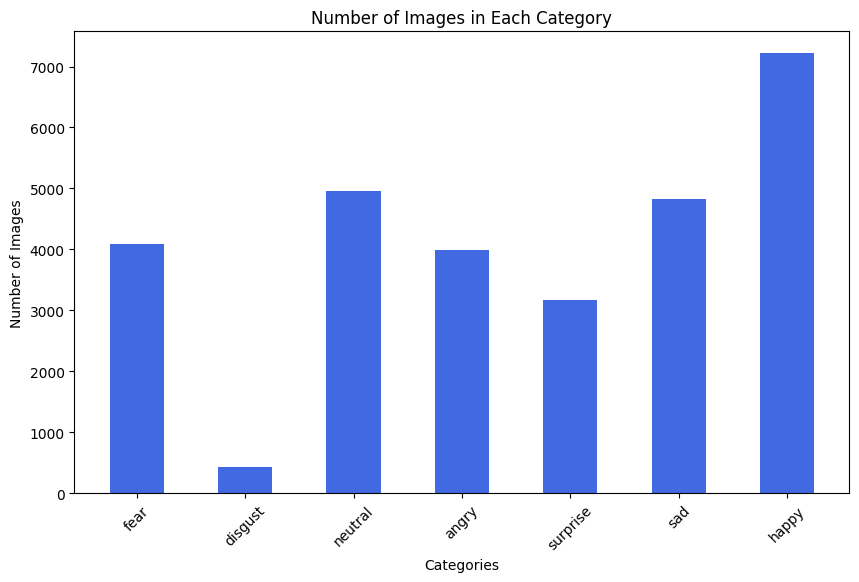

In [12]:
plot_no_of_images(train_dir)

## Creating Dataframes

In [13]:
train_data = []
test_data = []

def get_data(directory):
    data = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        for filename in os.listdir(label_dir):
            if filename.endswith('.jpg'):
                image_path = os.path.join(label_dir, filename)
                data.append({'label': label, 'path': image_path})
    return data

In [14]:
train_df = pd.DataFrame(get_data(train_dir))
test_df = pd.DataFrame(get_data(test_dir))

In [15]:
train_df.head()

,label,path
0,fear,./facial-expression-dataset/train/train/fear/T...
1,fear,./facial-expression-dataset/train/train/fear/T...
2,fear,./facial-expression-dataset/train/train/fear/T...
3,fear,./facial-expression-dataset/train/train/fear/T...
4,fear,./facial-expression-dataset/train/train/fear/T...


In [16]:
test_df.head()

,label,path
0,fear,./facial-expression-dataset/test/test/fear/Pub...
1,fear,./facial-expression-dataset/test/test/fear/Pri...
2,fear,./facial-expression-dataset/test/test/fear/Pub...
3,fear,./facial-expression-dataset/test/test/fear/Pri...
4,fear,./facial-expression-dataset/test/test/fear/Pri...


In [17]:
train_df.shape

(28709, 2)

In [18]:
test_df.shape

(7178, 2)

In [19]:
test_df['label'].unique()

array(['fear', 'disgust', 'neutral', 'angry', 'surprise', 'sad', 'happy'],
      dtype=object)

In [20]:
img_width, img_height = 48, 48
batch_size = 64
y_col = 'label'
x_col = 'path'
no_of_classes = len(train_df[y_col].unique())

In [21]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 28709 files belonging to 7 classes.


In [22]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode="categorical")

Found 7178 files belonging to 7 classes.


## ResNet50<br>

ResNet-50, short for "Residual Network 50," is a deep Convolutional Neural Network architecture. It is renowned for its depth, utilizing skip connections to combat the vanishing gradient problem, making it exceptionally effective in various computer vision tasks, such as image classification, object detection, and feature extraction.

### Modelling

In [23]:
resnet_model = tf.keras.models.Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(48,48,3),
                   pooling='max',classes=no_of_classes,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=True

resnet_model.add(pretrained_model)
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.07)))
resnet_model.add(tf.keras.layers.Dropout(0.6))
resnet_model.add(tf.keras.layers.Dense(24, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.07)))
resnet_model.add(tf.keras.layers.Dense(7, activation='softmax'))

94765736/94765736 [==============================] - 1s 0us/step


In [24]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 24)                49176     
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 7)                 175       
                                                                 
Total params: 23637663 (90.17 MB)
Trainable params: 2358

In [25]:


resnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
    )

In [26]:
epochs = 20

In [27]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

In [28]:
resnet_history = resnet_model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[early_stopping]
)

Epoch 1/20
449/449 [==============================] - 81s 82ms/step - loss: 6.0695 - accuracy: 0.2425 - val_loss: 4.8650 - val_accuracy: 0.3449
Epoch 2/20
449/449 [==============================] - 33s 72ms/step - loss: 4.0215 - accuracy: 0.3580 - val_loss: 3.1820 - val_accuracy: 0.4568
Epoch 3/20
449/449 [==============================] - 32s 72ms/step - loss: 2.7781 - accuracy: 0.4397 - val_loss: 2.3159 - val_accuracy: 0.5187
Epoch 4/20
449/449 [==============================] - 32s 72ms/step - loss: 2.1084 - accuracy: 0.5049 - val_loss: 1.9213 - val_accuracy: 0.5354
Epoch 5/20
449/449 [==============================] - 32s 71ms/step - loss: 1.7084 - accuracy: 0.5687 - val_loss: 1.7198 - val_accuracy: 0.5564
Epoch 6/20
449/449 [==============================] - 33s 73ms/step - loss: 1.4284 - accuracy: 0.6270 - val_loss: 1.7195 - val_accuracy: 0.5510
Epoch 7/20
449/449 [==============================] - 32s 72ms/step - loss: 1.2204 - accuracy: 0.6763 - val_loss: 1.6559 - val_accuracy:

In [29]:
resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(val_ds)
print(f"Test Loss: {resnet_test_loss}, Test Accuracy: {resnet_test_accuracy * 100:.2f}%")

113/113 [==============================] - 2s 17ms/step - loss: 1.6079 - accuracy: 0.5747
Test Loss: 1.607934594154358, Test Accuracy: 57.47%


In [30]:
resnet_model.save('resnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


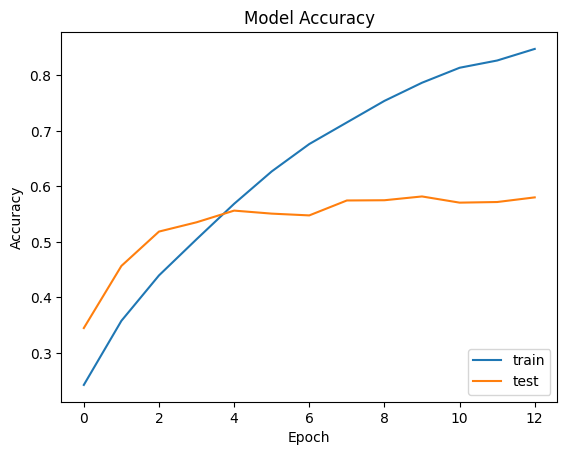

In [31]:
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### Testing

In [76]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report

def test_model(model):
    prefix = test_dir

    classes = os.listdir(prefix)

    choices = []
    predicted = []
    labels = []

    for i in range(6):
        temp = {}
        for j in range(5):
            ch = random.choice(classes)
            li = os.listdir(prefix+"/"+ch)
            file_ = prefix+"/"+ch+"/"+random.choice(li)
            temp[file_] = ch
            labels.append(ch)
            image = cv2.imread(file_)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = np.expand_dims(image, 0)
            predicted.append(train_ds.class_names[np.argmax(model.predict(image))])
        choices.append(temp)


    plt.figure(figsize=(20, 20))
    n = 4
    im = 8
    ct = 1
    c = 0
    for row in choices:
        for i in row:
            ax = plt.subplot(im, n, ct)
            ct = ct + 1
            image =  cv2.imread(i)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            plt.imshow(image)
            image = np.expand_dims(image, 0)
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            result = model.predict(image)[0]
            ax.set_title("True: {}, Predicted:{}".format(row[i], train_ds.class_names[np.argmax(result)]))
            #predicted.append(train_ds.class_names[np.argmax(result)])

    plt.show()

    conf_matrix = confusion_matrix(labels, predicted)
    # Print confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Calculate classification report containing precision, recall, F1-score, and support
    class_report = classification_report(labels, predicted)
    print("Classification Report:")
    print(class_report)

1/1 [==============================] - 0s 21ms/step


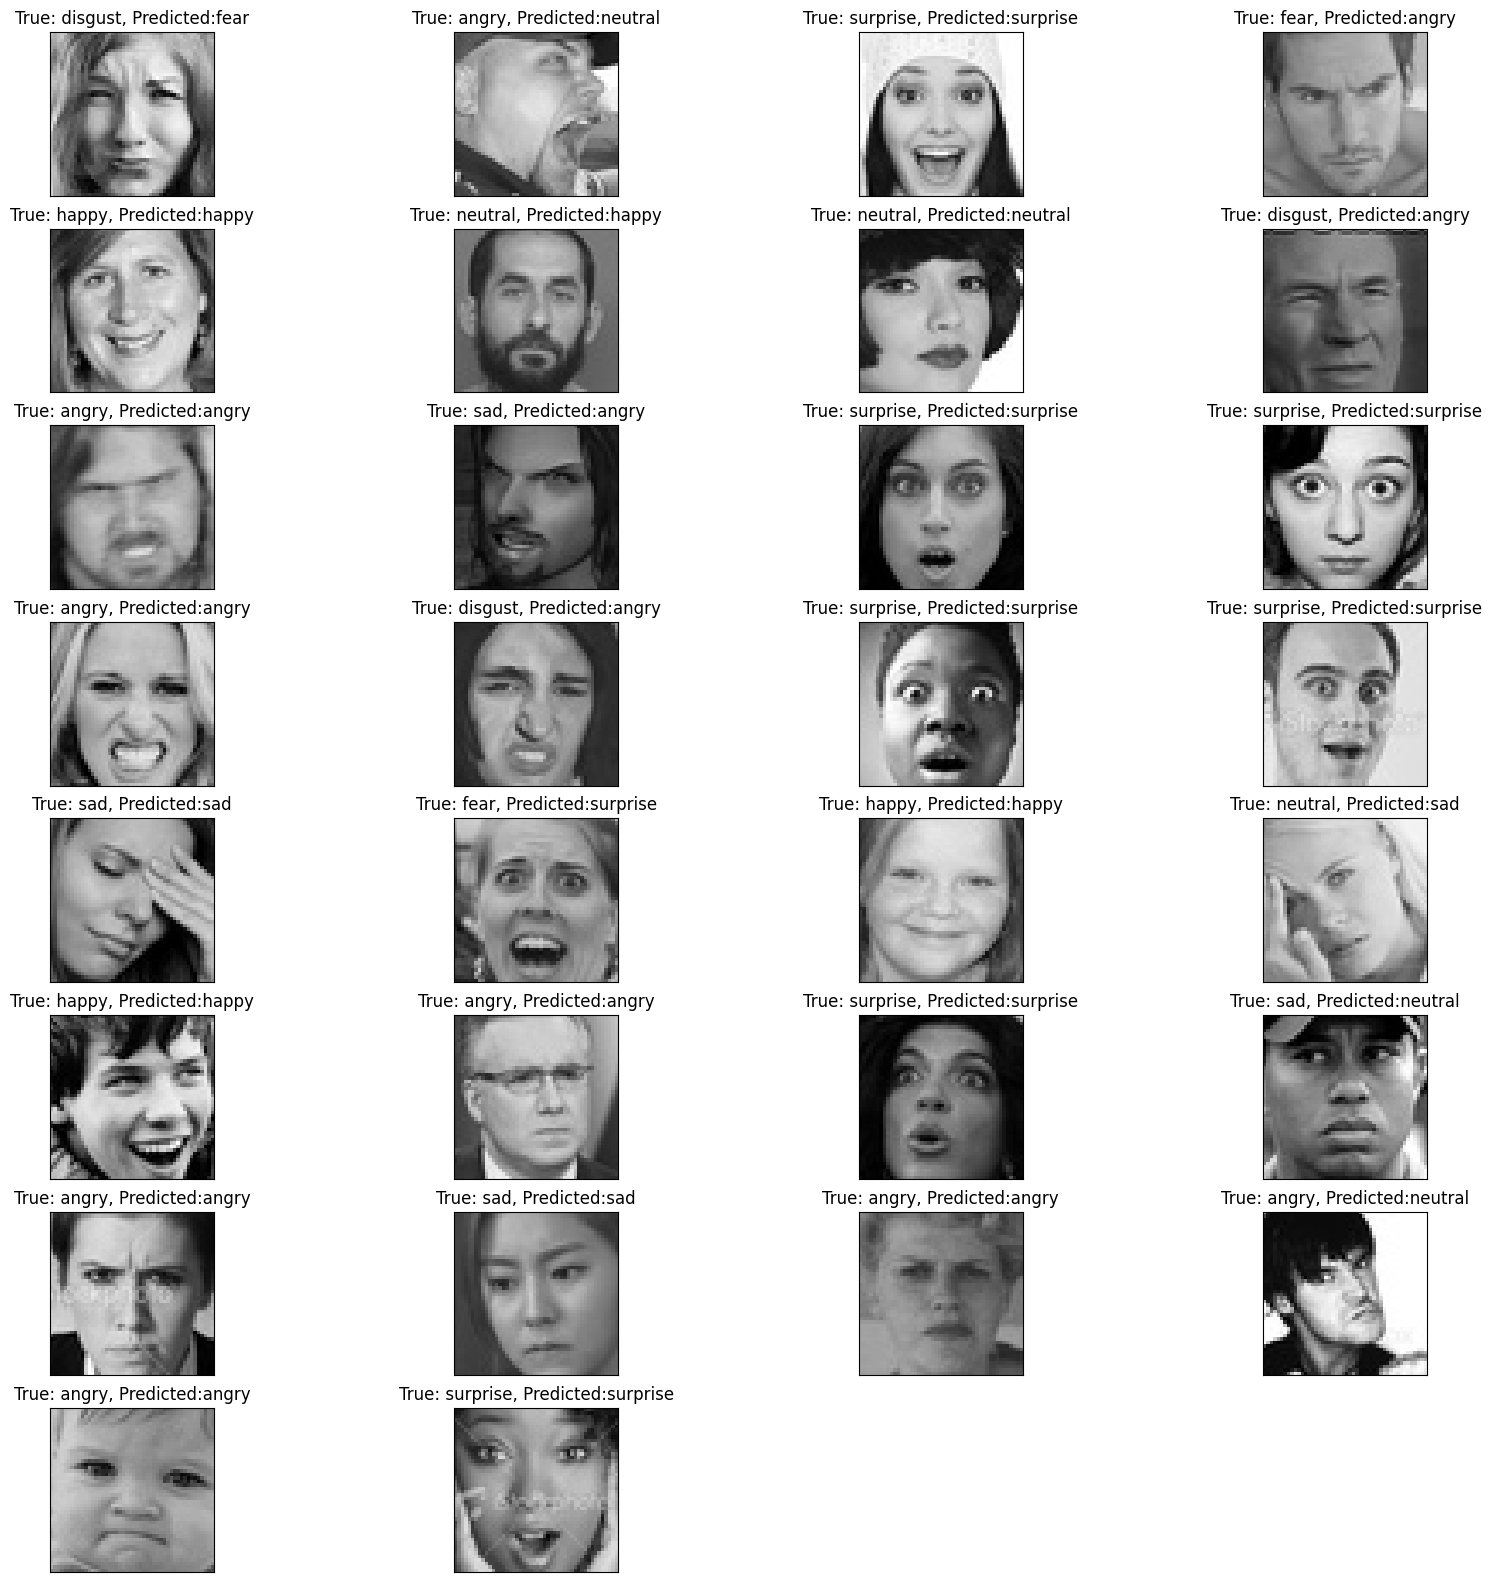

Confusion Matrix:
[[6 0 0 0 2 0 0]
 [2 0 1 0 0 0 0]
 [1 0 0 0 0 0 1]
 [0 0 0 3 0 0 0]
 [0 0 0 1 1 1 0]
 [1 0 0 0 1 2 0]
 [0 0 0 0 0 0 7]]
Classification Report:
              precision    recall  f1-score   support

       angry       0.60      0.75      0.67         8
     disgust       0.00      0.00      0.00         3
        fear       0.00      0.00      0.00         2
       happy       0.75      1.00      0.86         3
     neutral       0.25      0.33      0.29         3
         sad       0.67      0.50      0.57         4
    surprise       0.88      1.00      0.93         7

    accuracy                           0.63        30
   macro avg       0.45      0.51      0.47        30
weighted avg       0.55      0.63      0.59        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [77]:
test_model(resnet_model)

## EfficientNet

EfficientNet is a family of neural network architectures that balance computational efficiency and model accuracy. It introduces a compound scaling method that uniformly scales network depth, width, and resolution. This allows EfficientNet models to perform exceptionally well while being highly resource-efficient, making them suitable for various applications on edge devices and cloud platforms. EfficientNet has achieved state-of-the-art results in image classification tasks and has been widely adopted in areas like computer vision and transfer learning. Its adaptability to different resource constraints and tasks has made it a go-to choice for developing efficient deep learning models.

### Modelling

In [79]:
efficientnet_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

In [82]:
x = efficientnet_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(no_of_classes, activation='softmax')(x)

In [83]:
efficientnet_model = Model(inputs=efficientnet_base_model.input, outputs=predictions)

In [84]:
efficientnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)
validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [86]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

In [87]:
efficientnet_history = efficientnet_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
449/449 [==============================] - 72s 79ms/step - loss: 1.3835 - accuracy: 0.4754 - val_loss: 1.2357 - val_accuracy: 0.5380
Epoch 2/20
449/449 [==============================] - 32s 71ms/step - loss: 1.1319 - accuracy: 0.5782 - val_loss: 1.1841 - val_accuracy: 0.5497
Epoch 3/20
449/449 [==============================] - 36s 80ms/step - loss: 1.0092 - accuracy: 0.6275 - val_loss: 1.2007 - val_accuracy: 0.5563
Epoch 4/20
449/449 [==============================] - 33s 72ms/step - loss: 0.8964 - accuracy: 0.6728 - val_loss: 1.0653 - val_accuracy: 0.6152
Epoch 5/20
449/449 [==============================] - 33s 74ms/step - loss: 0.8096 - accuracy: 0.7071 - val_loss: 1.2000 - val_accuracy: 0.6078
Epoch 6/20
449/449 [==============================] - 31s 70ms/step - loss: 0.7066 - accuracy: 0.7456 - val_loss: 1.1165 - val_accuracy: 0.6190
Epoch 7/20
449/449 [==============================] - 34s 76ms/step - loss: 0.6111 - accuracy: 0.7821 - val_loss: 1.1879 - val_accuracy:

In [112]:
efficientnet_model.save('efficientnet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


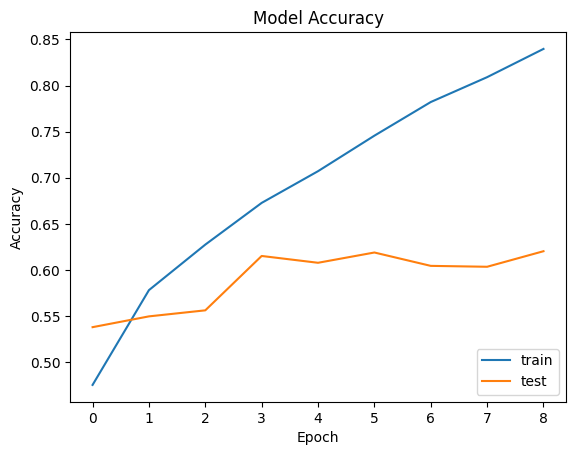

In [89]:
plt.plot(efficientnet_history.history['accuracy'])
plt.plot(efficientnet_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [90]:
effnet_test_loss, effnet_test_accuracy = efficientnet_model.evaluate(validation_generator)

113/113 [==============================] - 4s 38ms/step - loss: 1.0653 - accuracy: 0.6152


### Testing

1/1 [==============================] - 0s 22ms/step


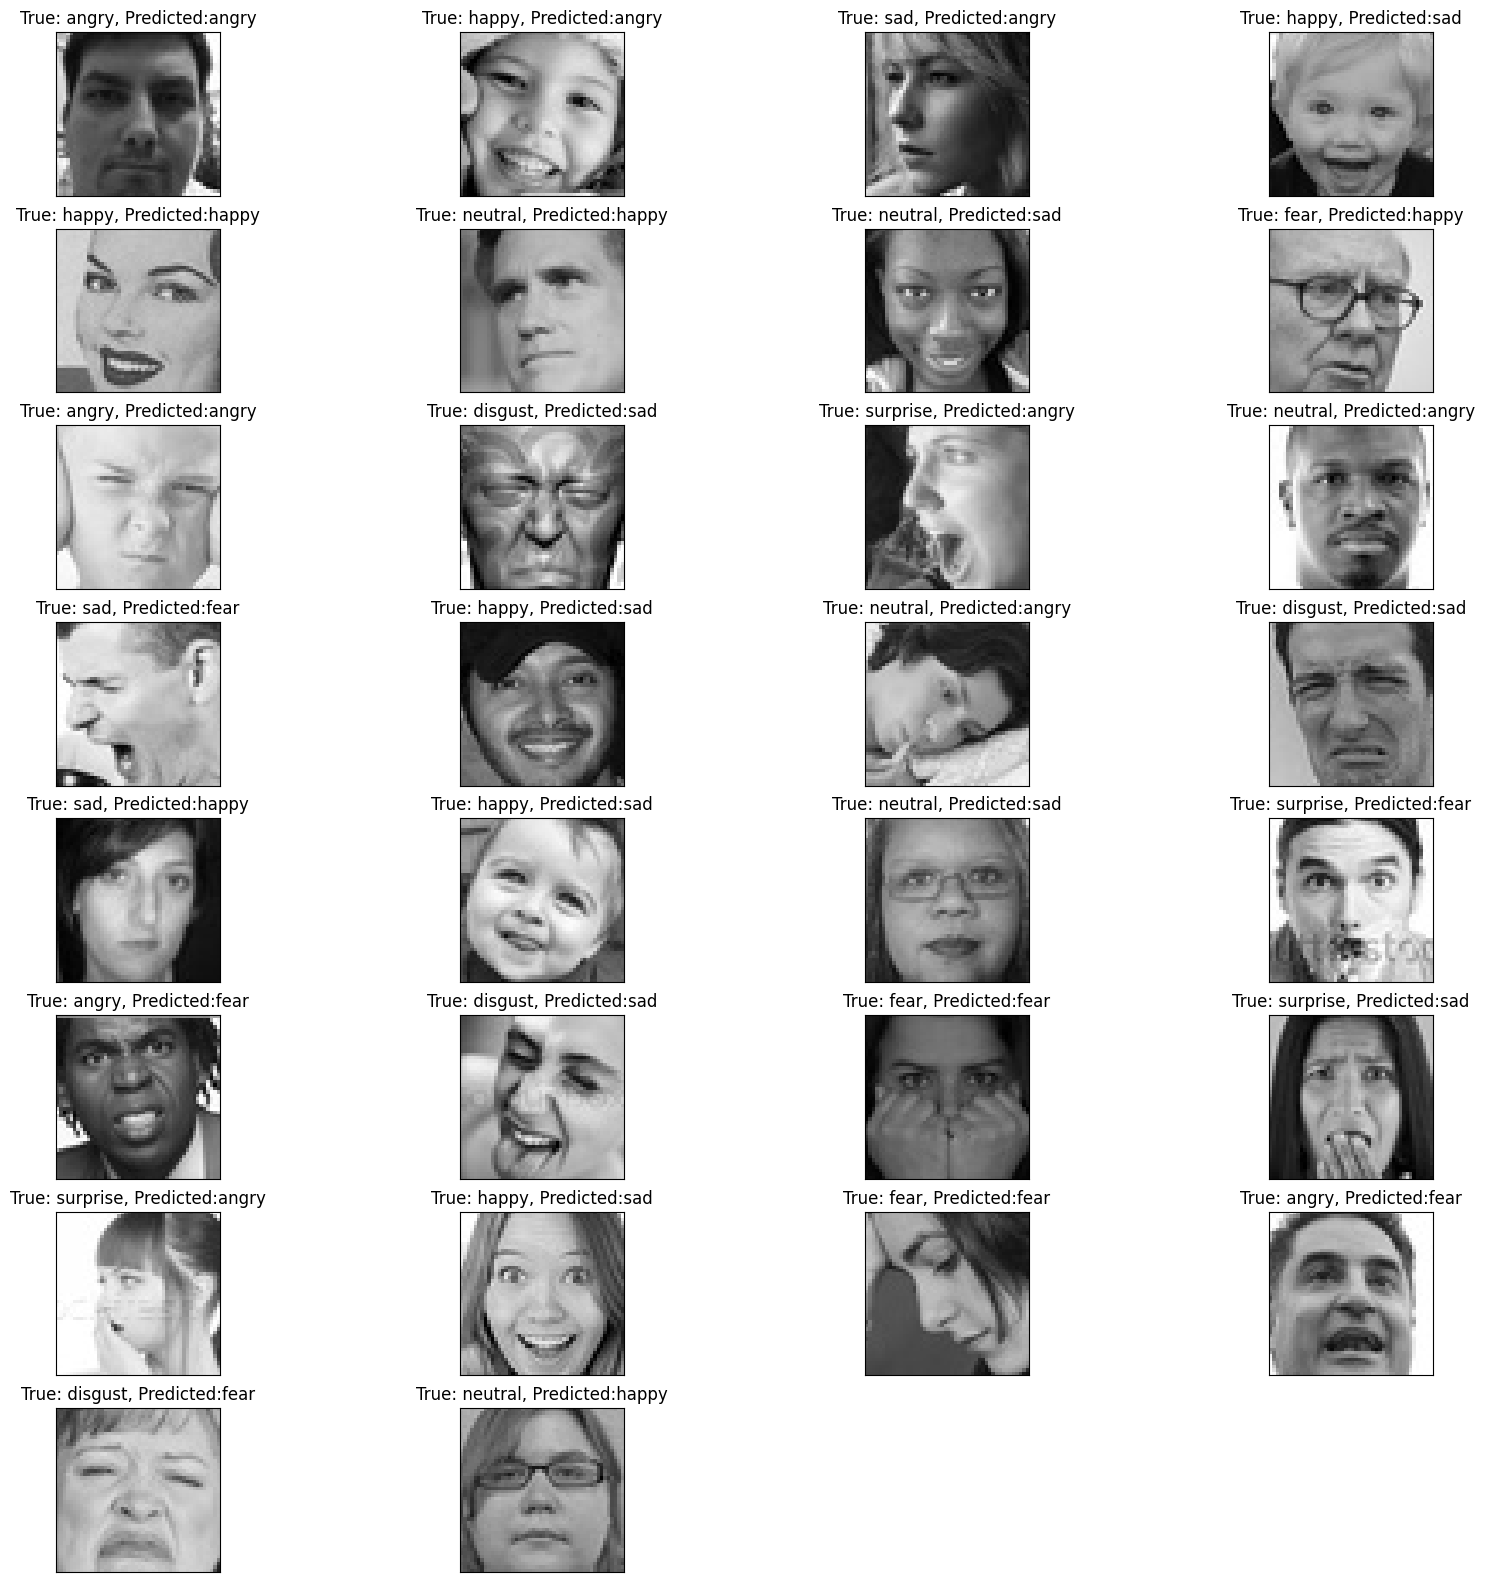

Confusion Matrix:
[[2 0 2 0 0 0 0]
 [0 0 1 0 0 3 0]
 [0 0 2 1 0 0 0]
 [1 0 0 1 0 4 0]
 [2 0 0 2 0 2 0]
 [1 0 1 1 0 0 0]
 [2 0 1 0 0 1 0]]
Classification Report:
              precision    recall  f1-score   support

       angry       0.25      0.50      0.33         4
     disgust       0.00      0.00      0.00         4
        fear       0.29      0.67      0.40         3
       happy       0.20      0.17      0.18         6
     neutral       0.00      0.00      0.00         6
         sad       0.00      0.00      0.00         3
    surprise       0.00      0.00      0.00         4

    accuracy                           0.17        30
   macro avg       0.11      0.19      0.13        30
weighted avg       0.10      0.17      0.12        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
test_model(efficientnet_model)

## CNN

### Modelling

In [92]:
cnn_model = Sequential()

cnn_model.add(Conv2D(64, (3, 3), padding='same', input_shape=(48, 48, 3)))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(128, (3, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(256, (3, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(512, (3, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Conv2D(512, (3, 3), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(512))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(512))
cnn_model.add(BatchNormalization())
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))

cnn_model.add(Dense(7, activation='softmax'))

In [93]:
optimizer = Adam(learning_rate=0.001)

In [94]:
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)      

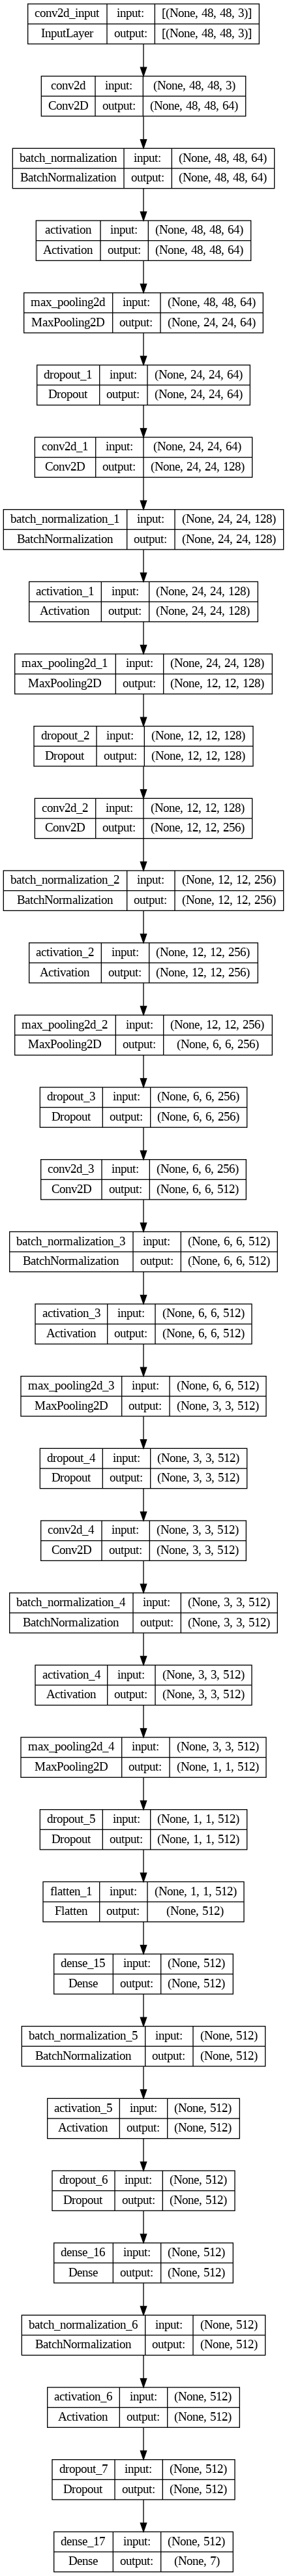

In [96]:
set_config(display="diagram")
plot_model(cnn_model, to_file='cnn_model_diagram.png', show_shapes=True, show_layer_names = True)

In [97]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

In [98]:
train_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [99]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [100]:
cnn_history = cnn_model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/20
449/449 [==============================] - 29s 49ms/step - loss: 2.0157 - accuracy: 0.2186 - val_loss: 1.9209 - val_accuracy: 0.2471
Epoch 2/20
449/449 [==============================] - 18s 40ms/step - loss: 1.6525 - accuracy: 0.3485 - val_loss: 1.6457 - val_accuracy: 0.3342
Epoch 3/20
449/449 [==============================] - 20s 44ms/step - loss: 1.4167 - accuracy: 0.4506 - val_loss: 1.4519 - val_accuracy: 0.4471
Epoch 4/20
449/449 [==============================] - 18s 40ms/step - loss: 1.3057 - accuracy: 0.4988 - val_loss: 1.3329 - val_accuracy: 0.4808
Epoch 5/20
449/449 [==============================] - 19s 42ms/step - loss: 1.2316 - accuracy: 0.5304 - val_loss: 1.2681 - val_accuracy: 0.5173
Epoch 6/20
449/449 [==============================] - 18s 40ms/step - loss: 1.1781 - accuracy: 0.5571 - val_loss: 1.7312 - val_accuracy: 0.3413
Epoch 7/20
449/449 [==============================] - 20s 43ms/step - loss: 1.1338 - accuracy: 0.5722 - val_loss: 1.1078 - val_accuracy:

In [101]:
cnn_model.save('cnn_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [102]:
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(validation_generator)

113/113 [==============================] - 3s 24ms/step - loss: 1.0583 - accuracy: 0.6010


In [103]:
print(f'Test Loss: {cnn_test_loss:.2f}')
print(f'Test Accuracy: {cnn_test_accuracy:.2%}')

Test Loss: 1.06
Test Accuracy: 60.10%


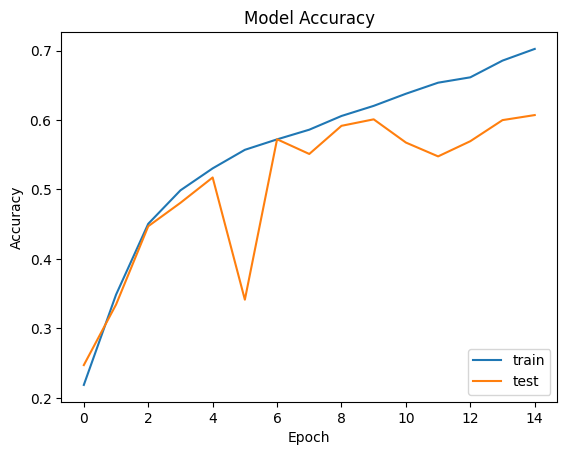

In [104]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

### Testing

1/1 [==============================] - 0s 26ms/step


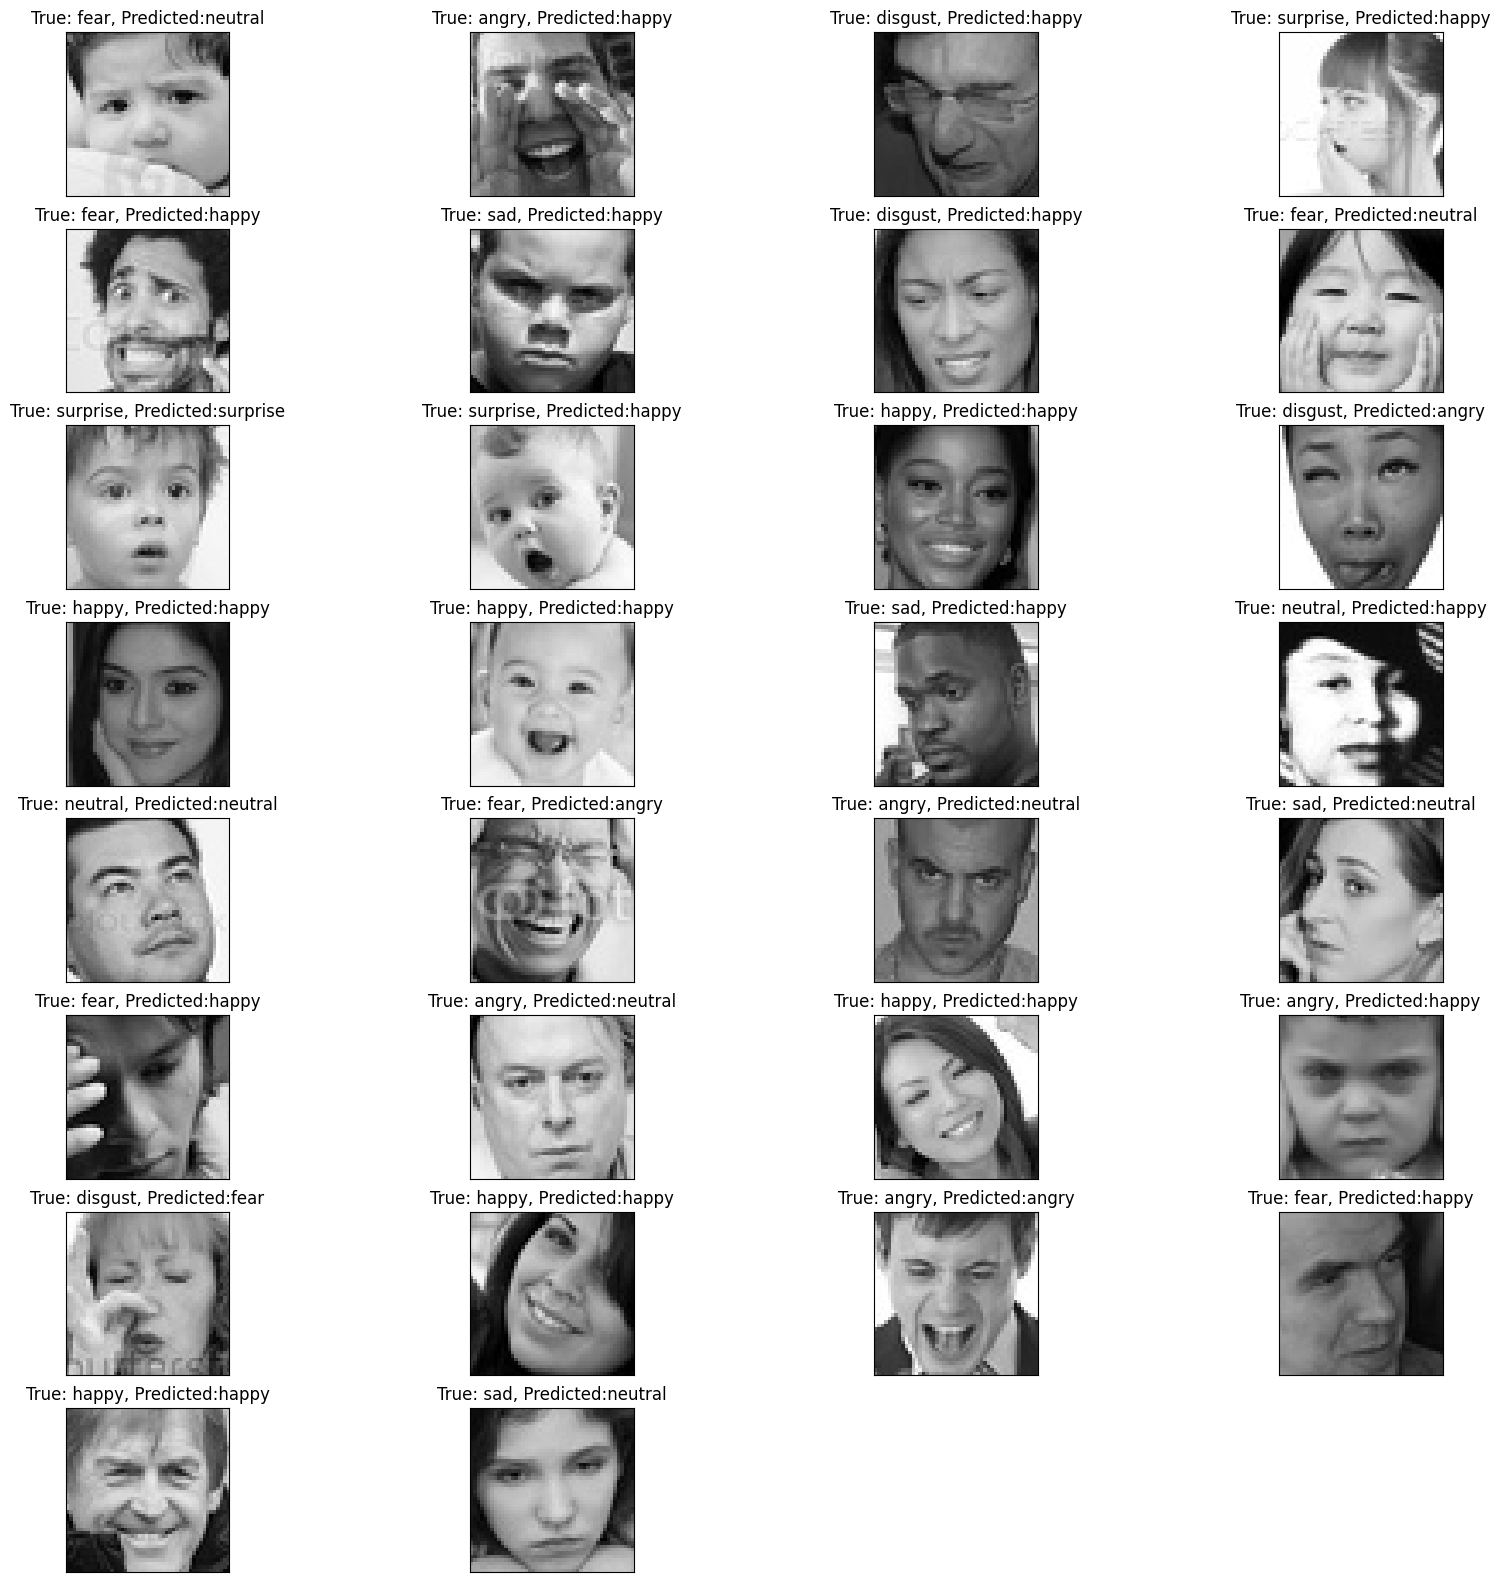

Confusion Matrix:
[[1 0 0 2 2 0 0]
 [1 0 1 2 0 0 0]
 [1 0 0 3 2 0 0]
 [0 0 0 6 0 0 0]
 [0 0 0 1 1 0 0]
 [0 0 0 2 2 0 0]
 [0 0 0 2 0 0 1]]
Classification Report:
              precision    recall  f1-score   support

       angry       0.33      0.20      0.25         5
     disgust       0.00      0.00      0.00         4
        fear       0.00      0.00      0.00         6
       happy       0.33      1.00      0.50         6
     neutral       0.14      0.50      0.22         2
         sad       0.00      0.00      0.00         4
    surprise       1.00      0.33      0.50         3

    accuracy                           0.30        30
   macro avg       0.26      0.29      0.21        30
weighted avg       0.23      0.30      0.21        30



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [105]:
test_model(cnn_model)

<IPython.core.display.Javascript object>

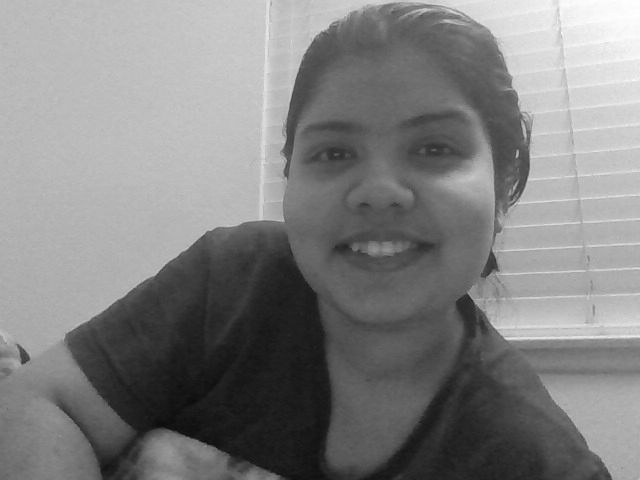

In [125]:
from google.colab.patches import cv2_imshow  # Required for displaying images in Colab
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import numpy as np
import io
from PIL import Image

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# Use the function to capture a photo
filename = take_photo()
# Load the photo into OpenCV
image = cv2.imread(filename)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# Now you can use the image with OpenCV as needed
cv2_imshow(gray_image)

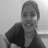

In [126]:

resized_gray_image = cv2.resize(gray_image, (48, 48), interpolation=cv2.INTER_AREA)
cv2_imshow(resized_gray_image)

In [128]:
resized_rgb_image = cv2.cvtColor(resized_gray_image, cv2.COLOR_GRAY2RGB)

# Resize RGB image to the input shape expected by EfficientNetB0
resized_rgb_image = cv2.resize(resized_rgb_image, (48, 48))

# Expand dimensions to create a batch of size 1
resized_rgb_image = np.expand_dims(resized_rgb_image, axis=0)

result = cnn_model.predict(resized_rgb_image)
print(train_ds.class_names[np.argmax(result)])



1/1 [==============================] - 0s 28ms/step
happy


## Comparitive Analysis

In [129]:
model_names = ["CNN", "ResNet50", "EfficientNet"]
accuracies = [0.6064, 0.5692, 0.6034]
loss = [1.06, 1.37, 1.08]

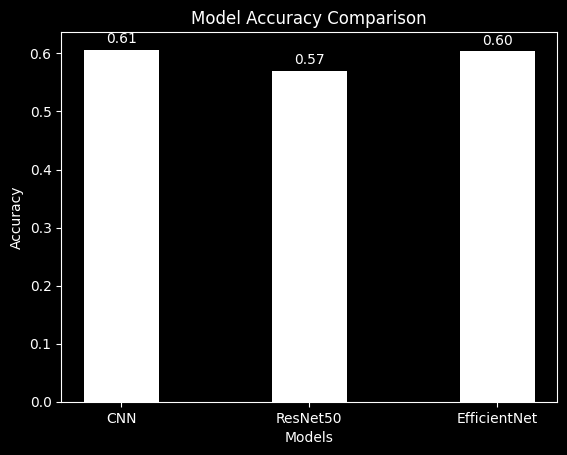

In [130]:
plt.style.use('dark_background')
fig, ax = plt.subplots()
bars = ax.bar(model_names, accuracies, width=0.4, color='white')
plt.xlabel('Models', color='white')
plt.ylabel('Accuracy', color='white')
plt.title('Model Accuracy Comparison', color='white')
plt.xticks(color='white')
plt.yticks(color='white')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom', color='white')
plt.show()

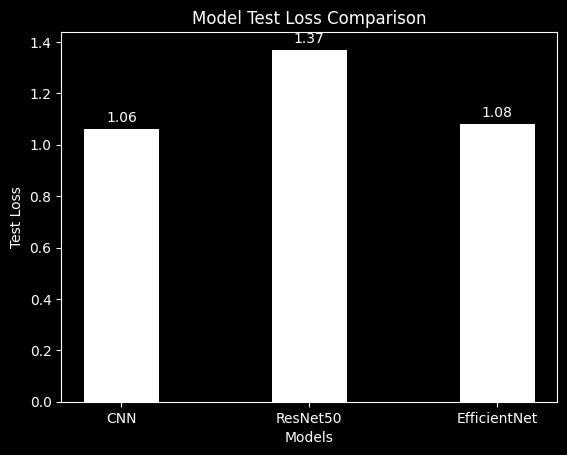

In [131]:
plt.style.use('dark_background')
fig, ax = plt.subplots()
bars = ax.bar(model_names, loss, width=0.4, color='white')
plt.xlabel('Models', color='white')
plt.ylabel('Test Loss', color='white')
plt.title('Model Test Loss Comparison', color='white')
plt.xticks(color='white')
plt.yticks(color='white')

for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords='offset points',
                ha='center', va='bottom', color='white')
plt.show()

In conclusion, our experimentation with three distinct deep learning models for facial expression recognition revealed varying performance levels. While ResNet achieved moderate accuracy (57.70%), both EfficientNet and CNN surpassed it with notably higher accuracies of 61.48% and 62.36% respectively. This suggests that more complex architectures such as EfficientNet and CNN may be more adept at capturing subtle nuances in facial expressions, offering promising avenues for further research and application in real-world scenarios.